# Fitting Bond ASW and Z-Spread Curves

Fitting a bond curve to asset swap spreads and z-scores, using the range of parametric functions provided

In [1]:
import os
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
from financepy.utils import *
from financepy.products.bonds import *
from financepy.products.rates.ibor_single_curve import IborSingleCurve
from financepy.products.rates.ibor_benchmarks_report import dataframe_to_benchmarks

### Load up some Bond and Curve Data

In [3]:
# Move into the local folder of notebook
%pwd
%cd notebooks/products/bonds/
%pwd


[WinError 3] The system cannot find the path specified: 'notebooks/products/bonds/'
C:\Users\domok\Dropbox\Desktop\RESEARCH_DB\FinancePy\Code\financepy-git\notebooks\products\bonds


'C:\\Users\\domok\\Dropbox\\Desktop\\RESEARCH_DB\\FinancePy\\Code\\financepy-git\\notebooks\\products\\bonds'

In [4]:

bond_dataframe = pd.read_csv("./data/giltbondprices.txt", sep='\t')
bond_dataframe['mid'] = 0.5*(bond_dataframe['bid'] + bond_dataframe['ask'])
bond_dataframe['maturity'] = pd.to_datetime(bond_dataframe['maturity'], format="%d-%b-%y")

In [5]:
bond_dataframe.head()
len(bond_dataframe)

33

In [6]:
dfbm = pd.read_csv('./data/GBP_OIS_20120919.csv', index_col=0)
dfbm['base_date'] = pd.to_datetime(dfbm['base_date'], dayfirst=True)
dfbm['base_date'] = pd.to_datetime(dfbm['base_date'], dayfirst=True)
dfbm['base_date'] = pd.to_datetime(dfbm['base_date'], dayfirst=True)
dfbm['base_date'] = pd.to_datetime(dfbm['base_date'], dayfirst=True)
dfbm['start_dt'] = pd.to_datetime(dfbm['start_dt'], dayfirst=True)  # allow tenors
dfbm['maturity_dt'] = pd.to_datetime(dfbm['maturity_dt'], dayfirst=True)  # allow tenors

In [7]:
valuation_date = from_datetime(dfbm.loc[0, 'base_date'])
cal = CalendarTypes.UNITED_KINGDOM
bms = dataframe_to_benchmarks(dfbm, asof_date=valuation_date, calendar_type=cal)
depos = bms['IborDeposit']
fras = bms['IborFRA']
swaps = bms['IborSwap']

fras.sort(key=lambda fra: fra.maturity_dt)
ois_curve = IborSingleCurve(valuation_date, depos, fras, swaps, InterpTypes.LINEAR_ZERO_RATES)

In [8]:
# SPECIFY UK BOND CONVENTIONS
freq_type = FrequencyTypes.SEMI_ANNUAL
accrual_type = DayCountTypes.ACT_ACT_ICMA
settlement = valuation_date

In [9]:
bonds = []
asws = []
z_spreads = []

# LOAD BONDS AND CREATE A VECTOR OF FINBOND AND THEIR CORRESPONDING asms/z-spreads

for index, bondData in bond_dataframe.iterrows():

    date_string = bondData['maturity']
    matDatetime = bondData['maturity']
    maturity_dt = from_datetime(matDatetime)
    coupon = bondData['coupon']/100.0
    clean_price = bondData['mid']
    issue_date = Date(maturity_dt.d, maturity_dt.m, 2000)
    bond = Bond(issue_date, maturity_dt, coupon, freq_type, accrual_type)

    z_spread = bond.z_spread(settlement, clean_price, ois_curve)
    asset_swap_spread = bond.asset_swap_spread(ois_curve.value_dt, clean_price, ois_curve)

    bonds.append(bond)
    asws.append(asset_swap_spread)
    z_spreads.append(z_spread)

### Eyeball asset swap spreads and z-spreads

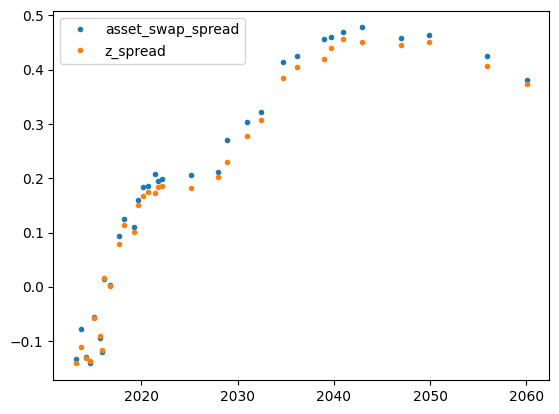

In [10]:
plt.plot(bond_dataframe['maturity'], np.array(asws)*100, '.', label='asset_swap_spread')
plt.plot(bond_dataframe['maturity'], np.array(z_spreads)*100, '.', label='z_spread')
plt.legend(loc='best')
plt.show()


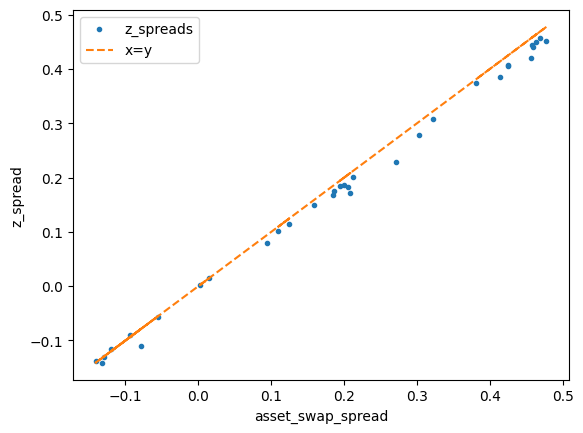

In [11]:
plt.plot(np.array(asws)*100, np.array(z_spreads)*100, '.', label='z_spreads')
plt.plot(np.array(asws)*100, np.array(asws)*100, '--', label = 'x=y')
plt.xlabel('asset_swap_spread')
plt.ylabel('z_spread')
plt.legend(loc='best')
plt.show()


## Fitting the Bond Curves

### Cubic Polynomial

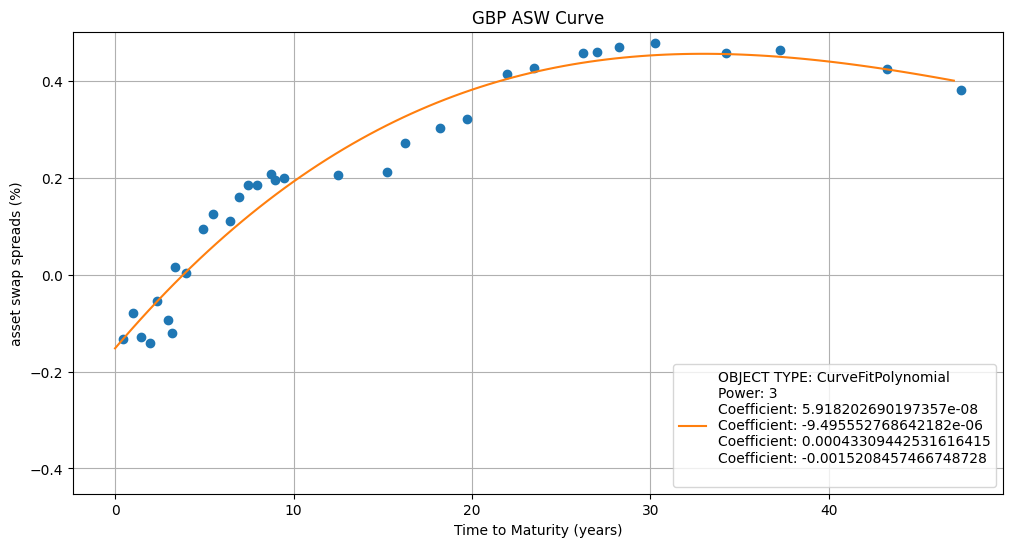

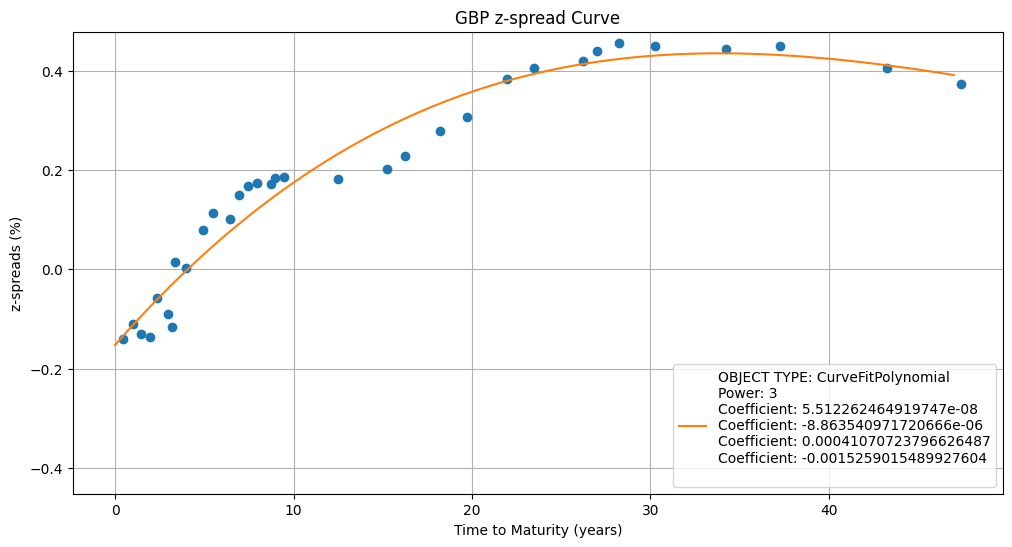

In [12]:
# FIT THE ASWS AND Z-SPREADS TO A CUBIC POLYNOMIAL
curve_fit_method = CurveFitPolynomial()
fittedCurve1a = BondYieldCurve(settlement, bonds, asws, curve_fit_method)
fittedCurve1a.plot("GBP ASW Curve", ylabel = 'asset swap spreads (%)')
fittedCurve1z = BondYieldCurve(settlement, bonds, z_spreads, curve_fit_method)
fittedCurve1z.plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

See the cubic coefficients

In [13]:
print(fittedCurve1a.curve_fit)

OBJECT TYPE: CurveFitPolynomial
Power: 3
Coefficient: 5.512262464919747e-08
Coefficient: -8.863540971720666e-06
Coefficient: 0.00041070723796626487
Coefficient: -0.0015259015489927604



### Quintic Polynomial

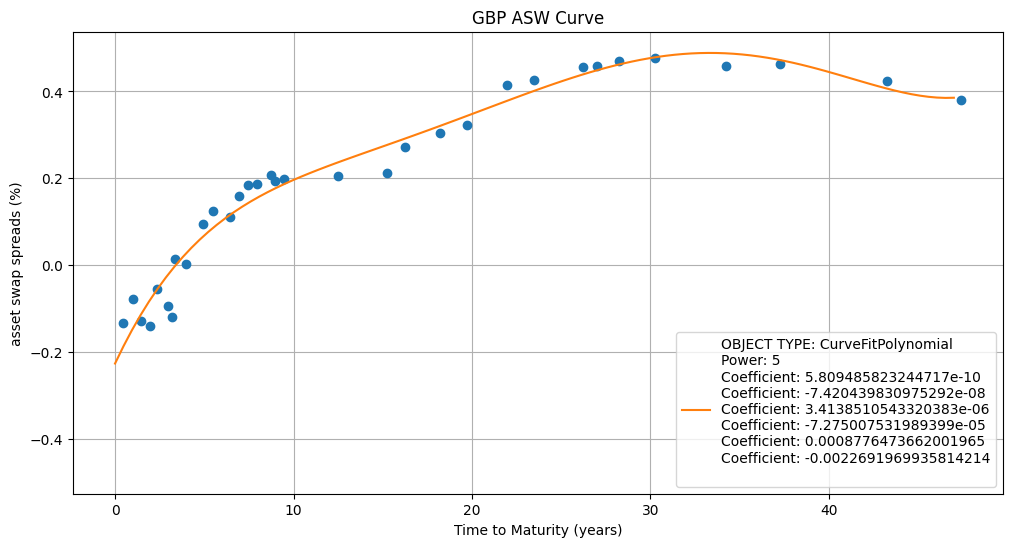

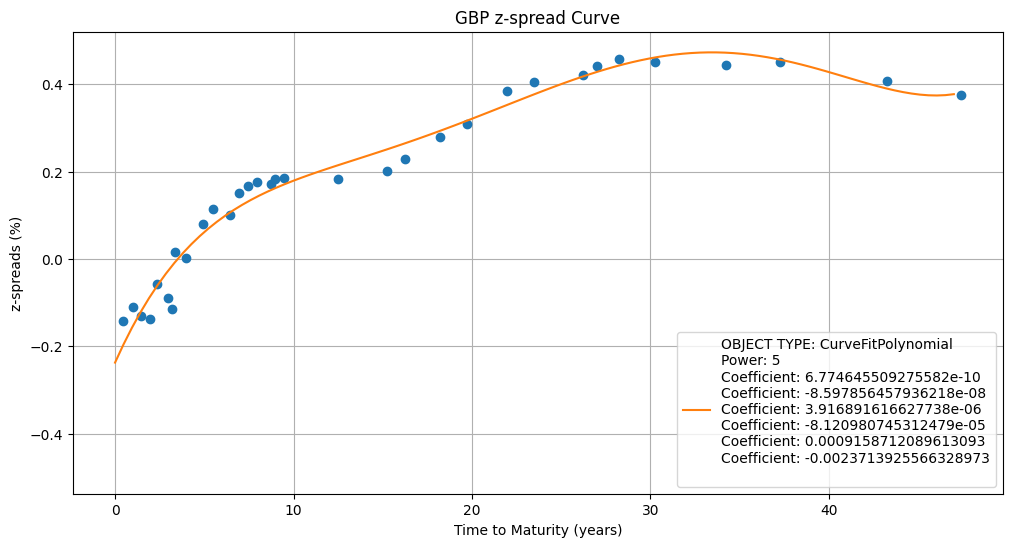

In [14]:
# FIT THE BOND ASWs and Z-SPREADs TO A QUINTIC POLYNOMIAL
curve_fit_method = CurveFitPolynomial(5)
fittedCurve2a = BondYieldCurve(settlement, bonds, asws, curve_fit_method)
fittedCurve2a.plot("GBP ASW Curve", ylabel = 'asset swap spreads (%)')
fittedCurve2z = BondYieldCurve(settlement, bonds, z_spreads, curve_fit_method)
fittedCurve2z.plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

See the quintic coefficients

In [15]:
print(fittedCurve2z.curve_fit)

OBJECT TYPE: CurveFitPolynomial
Power: 5
Coefficient: 6.774645509275582e-10
Coefficient: -8.597856457936218e-08
Coefficient: 3.916891616627738e-06
Coefficient: -8.120980745312479e-05
Coefficient: 0.0009158712089613093
Coefficient: -0.0023713925566328973



### Nelson-Siegel Curve

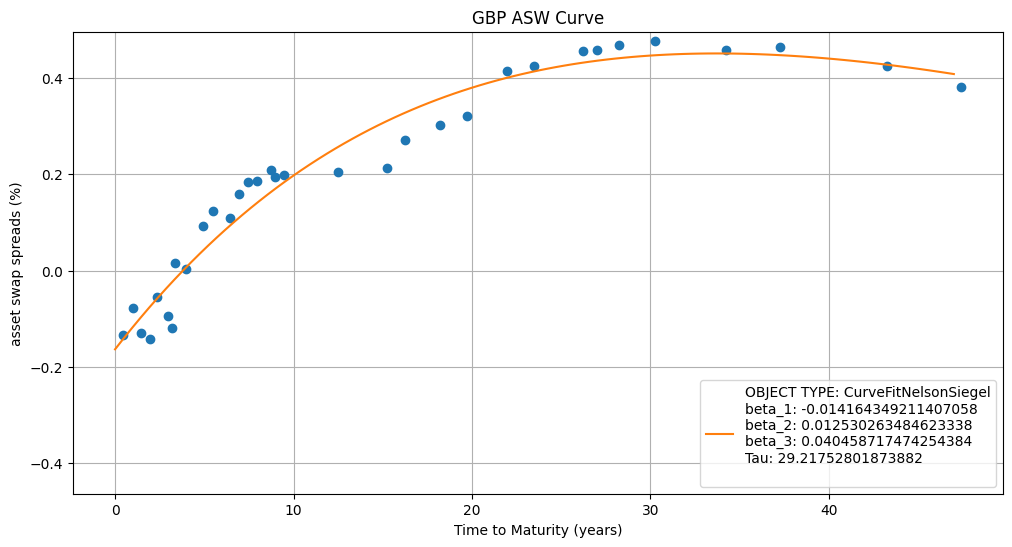

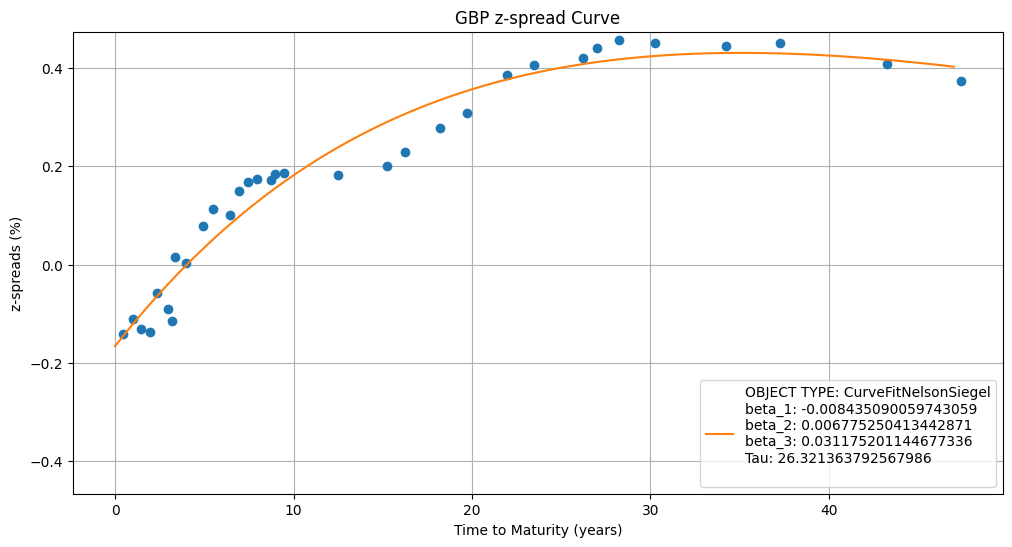

In [16]:
# FIT THE BONDS TO A NELSON-SIEGEL CURVE
curve_fit_method = CurveFitNelsonSiegel()
fittedCurve3a = BondYieldCurve(settlement, bonds, asws, curve_fit_method)
fittedCurve3a.plot("GBP ASW Curve", ylabel = 'asset swap spreads (%)')
fittedCurve3z = BondYieldCurve(settlement, bonds, z_spreads, curve_fit_method)
fittedCurve3z.plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

In [17]:
print(fittedCurve3a.curve_fit)

OBJECT TYPE: CurveFitNelsonSiegel
beta_1: -0.008435090059743059
beta_2: 0.006775250413442871
beta_3: 0.031175201144677336
Tau: 26.321363792567986



### Nelson-Siegel Svensson Curve

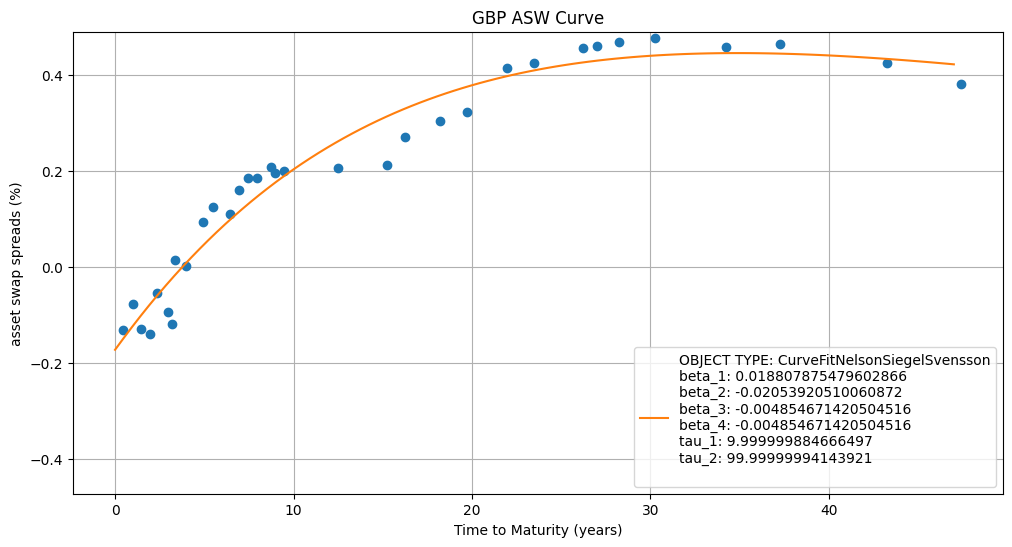

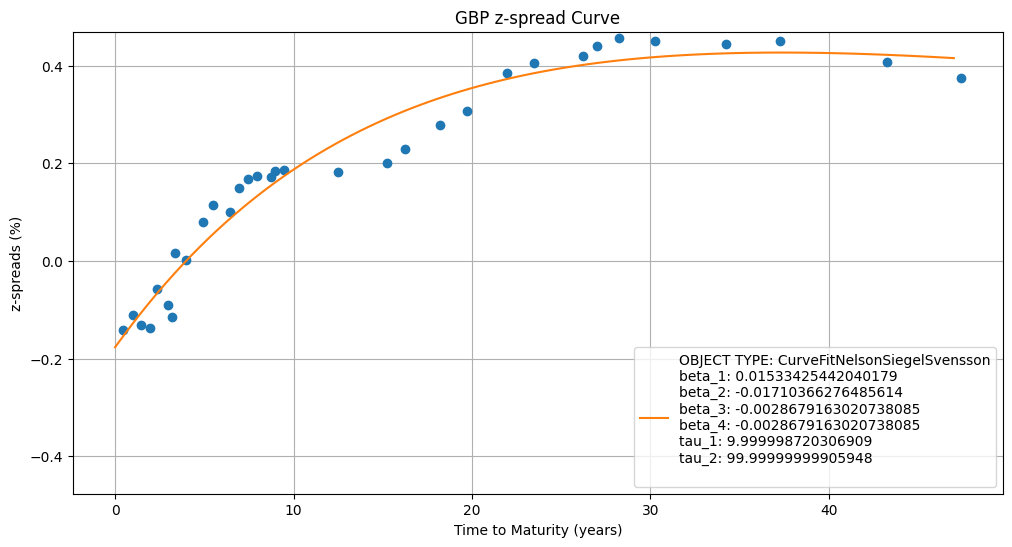

In [18]:
# FIT THE BONDS TO A NELSON-SIEGEL-SVENSSON CURVE
curve_fit_method = CurveFitNelsonSiegelSvensson()
fittedCurve4a = BondYieldCurve(settlement, bonds, asws, curve_fit_method)
fittedCurve4a.plot("GBP ASW Curve", ylabel = 'asset swap spreads (%)')
fittedCurve4z = BondYieldCurve(settlement, bonds, z_spreads, curve_fit_method)
fittedCurve4z.plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

In [19]:
print(fittedCurve4a.curve_fit)

OBJECT TYPE: CurveFitNelsonSiegelSvensson
beta_1: 0.01533425442040179
beta_2: -0.01710366276485614
beta_3: -0.0028679163020738085
beta_4: -0.0028679163020738085
tau_1: 9.999998720306909
tau_2: 99.99999999905948



### B-Spline Curve

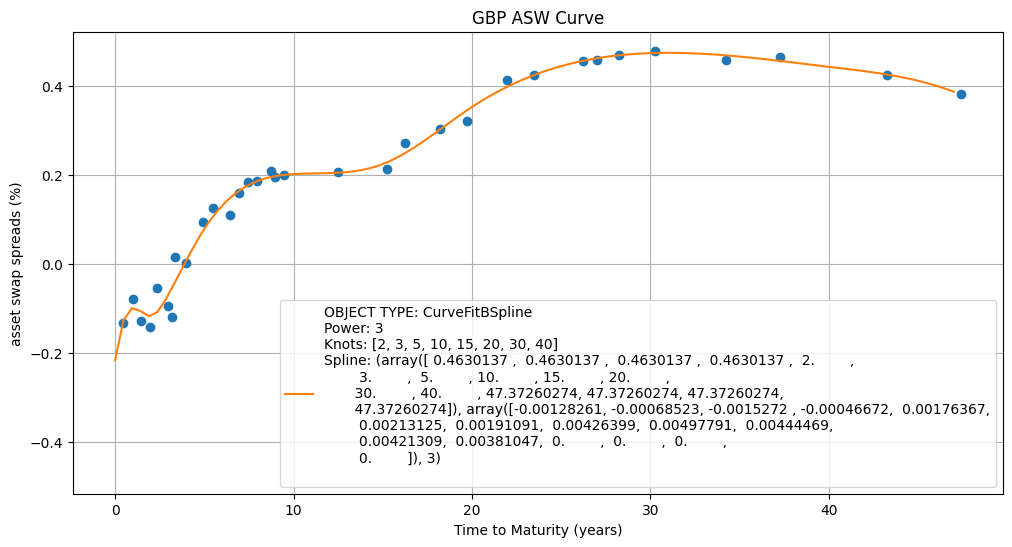

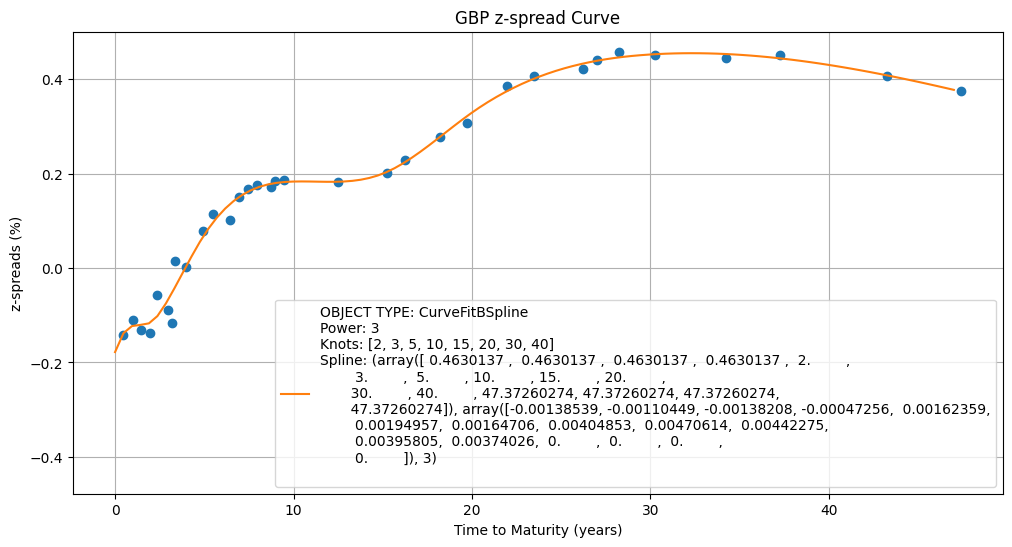

In [20]:
# FIT THE BONDS TO A B-SPLINE CURVE
curve_fit_method = CurveFitBSpline(power = 3, knots = [2, 3,5,10,15,20,30,40])
fittedCurve5a = BondYieldCurve(settlement, bonds, asws, curve_fit_method)
fittedCurve5a.plot("GBP ASW Curve", ylabel = 'asset swap spreads (%)')
fittedCurve5z = BondYieldCurve(settlement, bonds, z_spreads, curve_fit_method)
fittedCurve5z.plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

In [21]:
print(fittedCurve5a.curve_fit)

OBJECT TYPE: CurveFitBSpline
Power: 3
Knots: [2, 3, 5, 10, 15, 20, 30, 40]
Spline: (array([ 0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,  2.        ,
        3.        ,  5.        , 10.        , 15.        , 20.        ,
       30.        , 40.        , 47.37260274, 47.37260274, 47.37260274,
       47.37260274]), array([-0.00138539, -0.00110449, -0.00138208, -0.00047256,  0.00162359,
        0.00194957,  0.00164706,  0.00404853,  0.00470614,  0.00442275,
        0.00395805,  0.00374026,  0.        ,  0.        ,  0.        ,
        0.        ]), 3)



## Accessing the Curve

You can access a yield from a date as follows

In [22]:
# EXTRACT A YIELD FROM A FITTED YIELD CURVE
maturity_dt = Date(19, 9, 2030)
interpolated_yield = fittedCurve5a.interp_yield(maturity_dt)
print(maturity_dt, interpolated_yield*100)

19-SEP-2030 0.27196114918763215


## Vectorisations

You can also access the curve using a time and this can be vectorised.

In [23]:
times = np.linspace(0,10,100)

In [24]:
interpolated_yields = fittedCurve5z.interp_yield(times)

In [25]:
interpolated_yields*100

array([-0.17816644, -0.16682316, -0.15709381, -0.14885277, -0.14197442,
       -0.13633313, -0.13180328, -0.12825926, -0.12557544, -0.12362619,
       -0.1222859 , -0.12142894, -0.1209297 , -0.12066255, -0.12050186,
       -0.12032202, -0.11999741, -0.11940239, -0.11841136, -0.11689869,
       -0.114739  , -0.1118602 , -0.10830906, -0.10414841, -0.09944111,
       -0.09424999, -0.0886379 , -0.08266768, -0.07640219, -0.06990425,
       -0.06323652, -0.05644556, -0.04955073, -0.04256875, -0.03551634,
       -0.0284102 , -0.02126707, -0.01410364, -0.00693665,  0.00021719,
        0.00734117,  0.01441857,  0.02143266,  0.02836675,  0.0352041 ,
        0.041928  ,  0.04852173,  0.05496859,  0.06125184,  0.06735478,
        0.0732611 ,  0.07896424,  0.08446734,  0.08977395,  0.09488764,
        0.09981198,  0.10455054,  0.10910686,  0.11348452,  0.11768709,
        0.12171812,  0.12558118,  0.12927984,  0.13281765,  0.13619819,
        0.13942501,  0.14250168,  0.14543177,  0.14821883,  0.15